In [1]:
import os
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier

from utils import get_dataset

In [2]:
# get dataset, categorical indices, dimensions
dataset, cat_idxs, cat_dims = get_dataset(dataset_path="./data/uci_income/adult.csv", target="salary", train_size=0.8)
dataset_name = "UCI Income dataset"

In [3]:
X_train: np.ndarray
y_train: np.ndarray
X_valid: np.ndarray
y_valid: np.ndarray
X_test: np.ndarray
y_test: np.ndarray

X_train, y_train = dataset["train"]
X_valid, y_valid = dataset["valid"]
X_test,  y_test  = dataset["test"]

### Network parameters

In [4]:
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="entmax", # sparsemax
    n_shared=1,
    n_independent=1
)

Device used : cuda


### Self-Supervised Learning

In [5]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs,
    patience=5,
    batch_size=2048,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8
)

epoch 0  | loss: 2.90555 | val_0_unsup_loss: 1.32204 |  0:00:00s
epoch 1  | loss: 1.1561  | val_0_unsup_loss: 1.11431 |  0:00:01s
epoch 2  | loss: 1.09074 | val_0_unsup_loss: 1.07124 |  0:00:01s
epoch 3  | loss: 1.07536 | val_0_unsup_loss: 1.0386  |  0:00:02s
epoch 4  | loss: 1.06348 | val_0_unsup_loss: 1.00973 |  0:00:02s
epoch 5  | loss: 1.05255 | val_0_unsup_loss: 0.9809  |  0:00:03s
epoch 6  | loss: 1.03482 | val_0_unsup_loss: 0.94469 |  0:00:04s
epoch 7  | loss: 1.01406 | val_0_unsup_loss: 0.89858 |  0:00:04s
epoch 8  | loss: 0.98273 | val_0_unsup_loss: 0.85339 |  0:00:05s
epoch 9  | loss: 0.95383 | val_0_unsup_loss: 0.8136  |  0:00:05s
epoch 10 | loss: 0.9293  | val_0_unsup_loss: 0.79018 |  0:00:06s
epoch 11 | loss: 0.90196 | val_0_unsup_loss: 0.77768 |  0:00:06s
epoch 12 | loss: 0.8887  | val_0_unsup_loss: 0.77217 |  0:00:07s
epoch 13 | loss: 0.87733 | val_0_unsup_loss: 0.76654 |  0:00:07s
epoch 14 | loss: 0.86926 | val_0_unsup_loss: 0.76174 |  0:00:08s
epoch 15 | loss: 0.8605  

In [6]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape == embedded_X.shape)

In [7]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

### Save model

In [8]:
# save model
unsupervised_model.save_model('./models/uci_income/test_pretrain')

Successfully saved model at ./models/uci_income/test_pretrain.zip


'./models/uci_income/test_pretrain.zip'

In [9]:
# load pretrained model
pretrained_model = TabNetPretrainer()
pretrained_model.load_model("./models/uci_income/test_pretrain.zip")

Device used : cuda
Device used : cuda


### Supvervised Learning

In [10]:
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={"step_size": 10, "gamma": 0.9},
    mask_type="sparsemax"
)

Device used : cuda


In [11]:
clf.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=["train", "valid"],
    eval_metric=["auc"],
    max_epochs=max_epochs,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=pretrained_model
)

Loading weights from unsupervised pretraining


/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [74, 9, 16, 16, 7, 15, 6, 5, 2, 123, 99, 96, 42]
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_independent changed from 2 to 1
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_sha

epoch 0  | loss: 0.472   | train_auc: 0.89133 | valid_auc: 0.89367 |  0:00:01s
epoch 1  | loss: 0.36451 | train_auc: 0.91662 | valid_auc: 0.91767 |  0:00:02s
epoch 2  | loss: 0.34795 | train_auc: 0.9233  | valid_auc: 0.92114 |  0:00:03s
epoch 3  | loss: 0.33462 | train_auc: 0.91994 | valid_auc: 0.91908 |  0:00:04s
epoch 4  | loss: 0.33219 | train_auc: 0.92927 | valid_auc: 0.92714 |  0:00:05s
epoch 5  | loss: 0.33186 | train_auc: 0.92727 | valid_auc: 0.92456 |  0:00:06s
epoch 6  | loss: 0.32336 | train_auc: 0.93383 | valid_auc: 0.93037 |  0:00:06s
epoch 7  | loss: 0.32404 | train_auc: 0.93509 | valid_auc: 0.93157 |  0:00:07s
epoch 8  | loss: 0.32729 | train_auc: 0.9354  | valid_auc: 0.93332 |  0:00:08s
epoch 9  | loss: 0.32321 | train_auc: 0.93551 | valid_auc: 0.93296 |  0:00:09s
epoch 10 | loss: 0.32139 | train_auc: 0.93734 | valid_auc: 0.93323 |  0:00:10s
epoch 11 | loss: 0.31702 | train_auc: 0.9376  | valid_auc: 0.9331  |  0:00:11s
epoch 12 | loss: 0.31682 | train_auc: 0.93738 | vali

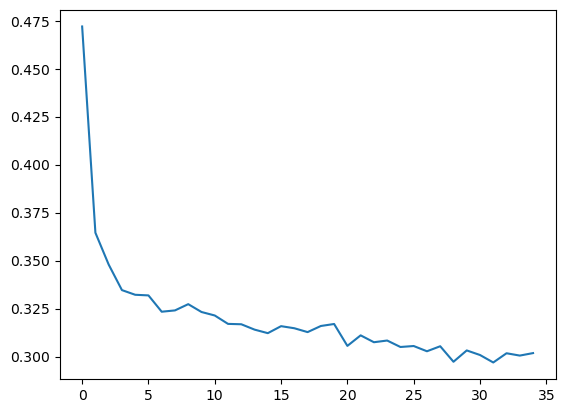

In [12]:
# plot losses
plt.plot(clf.history['loss'])

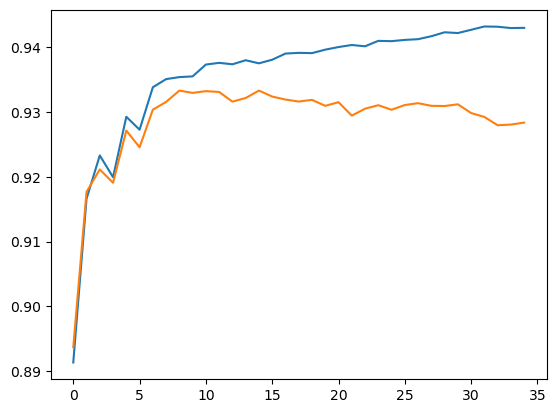

In [13]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

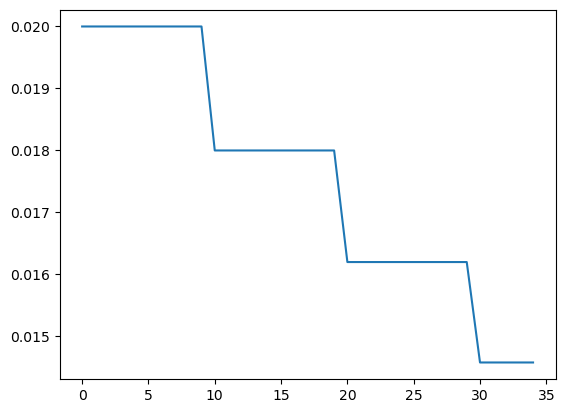

In [14]:
# plot learning rates
plt.plot(clf.history['lr'])

### Prediction

In [15]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR UCI Income dataset : 0.933317148692132
FINAL TEST SCORE FOR UCI Income dataset : 0.9244370729681779


In [16]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

### Save and load Model

In [17]:
# save tabnet model
saving_path_name = "./models/uci_income/tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)


Successfully saved model at ./models/uci_income/tabnet_model_test_1.zip


In [18]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cuda
Device used : cuda


In [19]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR UCI Income dataset : 0.9244370729681779


In [20]:
assert(test_auc == loaded_test_auc)